## 02. Model Training

In [1]:
# Библиотеки
import import_ipynb
from ml_utils import split_data, save_model_predictions
from ml_utils import calculate_metrics, print_metrics, print_advanced_metrics, save_evaluation_polygon_geometry 
from ml_utils import plot_predictions_vs_true, visualisation_polygon_form_metrics

from config import PROCESSED_CSV_PATH, RESULTS_DIR, CENTROIDS_CSV_PATH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from IPython.display import HTML
from IPython.display import display

metrics_list = []

MODE = "CENTROIDS" # "POINTS" or "CENTROIDS"

GLOBAL_VERSION = "v1c.0"

LR_VERSION = "v2c.0"
MLP_VERSION = "v1c.0"
HGB_VERSION = "v1c.0"
XGB_VERSION = "v1c.0"


In [2]:
# Сбор статистики по моделям
def collect_metrics_dict(model_name, y_true, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target):
    col_1, col_2 = y_true.columns[:2]

    # Средняя широта — для перевода градусов в метры
    mean_lat = y_true[col_2].mean()
    lon_factor = 111320 * np.cos(np.radians(mean_lat))
    lat_factor = 111000

    # Ошибки в градусах
    mae_1_deg, mae_2_deg = mae_per_target
    rmse_1_deg, rmse_2_deg = rmse_per_target

    # Ошибки в метрах (предполагаем, что целевые всё ещё в градусах)
    mae_1_m = mae_1_deg * lon_factor
    mae_2_m = mae_2_deg * lat_factor

    # R2 Score
    r2_1, r2_2 = r2_score_per_target
    r2_mean = r2_score


    # MAPE (в процентах)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true.values - y_pred) / y_true.values)) * 100
        mape_1 = np.mean(np.abs((y_true[col_1] - y_pred[:, 0]) / y_true[col_1])) * 100
        mape_2 = np.mean(np.abs((y_true[col_2] - y_pred[:, 1]) / y_true[col_2])) * 100

    return {
        "model": model_name,
        "MAE (°)": np.mean(mae_per_target),
        "RMSE (°)": np.mean(rmse_per_target),
        f"MAE {col_1} (°)": mae_1_deg,
        f"MAE {col_2} (°)": mae_2_deg,
        f"MAE {col_1} (m)": mae_1_m,
        f"MAE {col_2} (m)": mae_2_m,
        "MAPE (%)": mape,
        f"MAPE {col_1} (%)": mape_1,
        f"MAPE {col_2} (%)": mape_2,
        f"R2 {col_1}": r2_1,
        f"R2 {col_2}": r2_2,
        f"R2 ": r2_mean,
        "n_samples": len(y_true)
    }

#### 🔹 1. Загрузка points_processed.csv

In [3]:
# df_data = pd.read_csv(PROCESSED_CSV_PATH) # версия v1.0 (по точкам)
df_data = pd.read_csv(CENTROIDS_CSV_PATH) # версия v1.1 (по полигонам)

In [4]:
# "нулевая зона" даёт отклонения в 2000 км, поэтому удаляем её из тренировочной выборки
df_filtered = df_data[df_data["zone"] != 0].copy()
print(f"Удалено {len(df_data) - len(df_filtered)} строк с нулевой зоной")

Удалено 42 строк с нулевой зоной


In [5]:
display(HTML(df_filtered.head(10).to_html(index=False)))

number,wgs84_centroid_lon,wgs84_centroid_lat,polygon_area_wgs84,sc63_centroid_x,sc63_centroid_y,polygon_area_sc63,area_ratio,wgs84_centroid_baseline_lat,wgs84_centroid_baseline_lon,zone,delta_lon_from_baseline,delta_lat_from_baseline
0520281400:01:004:0012,27.460983,48.929602,56194.50,2370539.90,5413153.67,24235.14,2.318720,48.929649,27.461045,2.0,0.000062,0.000047
0520281400:01:004:0071,27.480806,48.921421,65491.63,2372004.17,5412262.49,28286.31,2.315312,48.921468,27.480869,2.0,0.000063,0.000047
0520281400:01:005:0003,27.475348,48.919075,67995.75,2371607.49,5411996.38,29400.69,2.312726,48.919121,27.475410,2.0,0.000062,0.000046
0520281400:02:003:0127,27.427966,48.902435,42069.50,2368157.52,5410102.67,18188.24,2.313006,48.902484,27.428028,2.0,0.000062,0.000049
0520282600:04:016:0020,27.755919,48.822751,23044.75,2392346.74,5401586.58,9999.96,2.304484,48.822798,27.755978,2.0,0.000059,0.000047
0520282600:04:016:0030,27.752389,48.822108,7553.50,2392088.67,5401510.73,3290.22,2.295743,48.822154,27.752447,2.0,0.000058,0.000046
0520282600:04:016:0031,27.759134,48.821621,22642.37,2392584.89,5401464.77,9807.35,2.308714,48.821667,27.759193,2.0,0.000059,0.000046
0520282600:04:016:0041,27.755437,48.827270,5686.75,2392303.15,5402088.39,2472.36,2.300130,48.827316,27.755497,2.0,0.000060,0.000046
0520282600:04:016:0047,27.761273,48.822452,30184.63,2392740.35,5401559.70,13083.90,2.307006,48.822498,27.761330,2.0,0.000057,0.000046
0520481300:03:001:0318,29.677593,48.215175,1007.25,3313319.33,5333272.69,449.30,2.241821,48.215220,29.677650,3.0,0.000057,0.000045


#### 🔹 2. Разбиение на train/test по `number`

In [6]:
#x_features = ["sc63_x", "sc63_y"] ver 1.0
#x_features = ["sc63_x", "sc63_y", "vertex_id_norm"] ver 2.0
#x_features = ["sc63_x", "sc63_y", "vertex_id_norm", "sc63_centroid_x", "sc63_centroid_y"] # ver 3.0
x_features = ["wgs84_centroid_baseline_lon", "wgs84_centroid_baseline_lat", "zone"] # ver 1c.0

#y_feature = ["wgs84_lon", "wgs84_lat"] ver 1.0, 2.0, 3.0
y_feature = ["delta_lon_from_baseline", "delta_lat_from_baseline"] # ver 1c.0

X_train, X_test, y_train, y_test, X_train_full, X_test_full = split_data(df_filtered, x_features, y_feature, Keep_Numbers=True)

In [7]:
X_train_full.isna().sum()

number                         0
wgs84_centroid_lon             0
wgs84_centroid_lat             0
polygon_area_wgs84             0
sc63_centroid_x                0
sc63_centroid_y                0
polygon_area_sc63              0
area_ratio                     0
wgs84_centroid_baseline_lat    0
wgs84_centroid_baseline_lon    0
zone                           0
delta_lon_from_baseline        0
delta_lat_from_baseline        0
dtype: int64

In [8]:
missing_centroids = X_train_full[X_train_full["wgs84_centroid_lon"].isna()]["number"].unique()
print("🧩 Участков без центроидов:", len(missing_centroids))
display(missing_centroids)
display(X_train_full[X_train_full["wgs84_centroid_lon"].isna()])

🧩 Участков без центроидов: 0


array([], dtype=object)

,number,wgs84_centroid_lon,wgs84_centroid_lat,polygon_area_wgs84,sc63_centroid_x,sc63_centroid_y,polygon_area_sc63,area_ratio,wgs84_centroid_baseline_lat,wgs84_centroid_baseline_lon,zone,delta_lon_from_baseline,delta_lat_from_baseline


#### 🔹 3. Обучение моделей:

##### - Linear Regression

### 🧮 Linear Regression (LR)

- Описание: Простая модель, предполагающая линейную зависимость между признаками и целевой переменной.
- Параметры: без параметров.
- Плюсы: быстро, интерпретируемо.
- Минусы: плохо работает с выбросами, не моделирует сложные зависимости.

### 🧮 Ridge / Lasso / ElasticNet

- Описание: Модификации линейной регрессии с регуляризацией:

Ridge — L2-регуляризация (наказание за крупные веса);

Lasso — L1-регуляризация (может занулять веса);

### ElasticNet — смесь L1 и L2.

- Параметры: alpha=1.0 (по умолчанию), можно варьировать.
- Плюсы: борются с переобучением, устойчивее, чем LR.
- Минусы: ограничены линейными зависимостями.

### 🛠 RANSAC Regressor

- Описание: Модель, устойчивая к выбросам. Обучается на случайных подмножествах и выбирает наилучшую «основную» модель.

Параметры:
- min_samples — доля данных для каждой итерации;
- residual_threshold — отклонение, считающееся выбросом;
- max_trials — число попыток.
- Плюсы: устойчива к шуму и выбросам.
- Минусы: дольше обучается, может не сойтись при плохих данных.

=== y_test ===
<class 'pandas.core.frame.DataFrame'>
(1973, 2)
Index(['delta_lon_from_baseline', 'delta_lat_from_baseline'], dtype='object')
=== y_pred ===
<class 'numpy.ndarray'>
(1973, 2)
✅ Poly2 + LR saving corrected predictions
✅ Saved: ./mnt/results/predictions_Poly2 + LR_v2c.0.csv
Metrics:
MAE = 0.000029
RMSE = 0.000309
MAE per target = [2.42676365e-05 3.33575592e-05]
RMSE per target = [0.00032818 0.00029066]
R2 per target = [ 0.00305458 -0.01404668]
R2 = -0.0054960481431752806
--------------------


,Value
Metric,
MAE (°),0.000029
RMSE (°),0.000309
MAE по delta_lon_from_baseline (°),0.000024
MAE по delta_lat_from_baseline (°),0.000033
RMSE по delta_lon_from_baseline (°),0.000328
RMSE по delta_lat_from_baseline (°),0.000291
MAE по delta_lon_from_baseline (м),2.700000
MAE по delta_lat_from_baseline (м),3.700000
MAPE (%),29.280000


Mean y_true: [6.64571385e-05 5.96952373e-05]
Mean y_pred: [6.83543315e-05 4.13999971e-05]


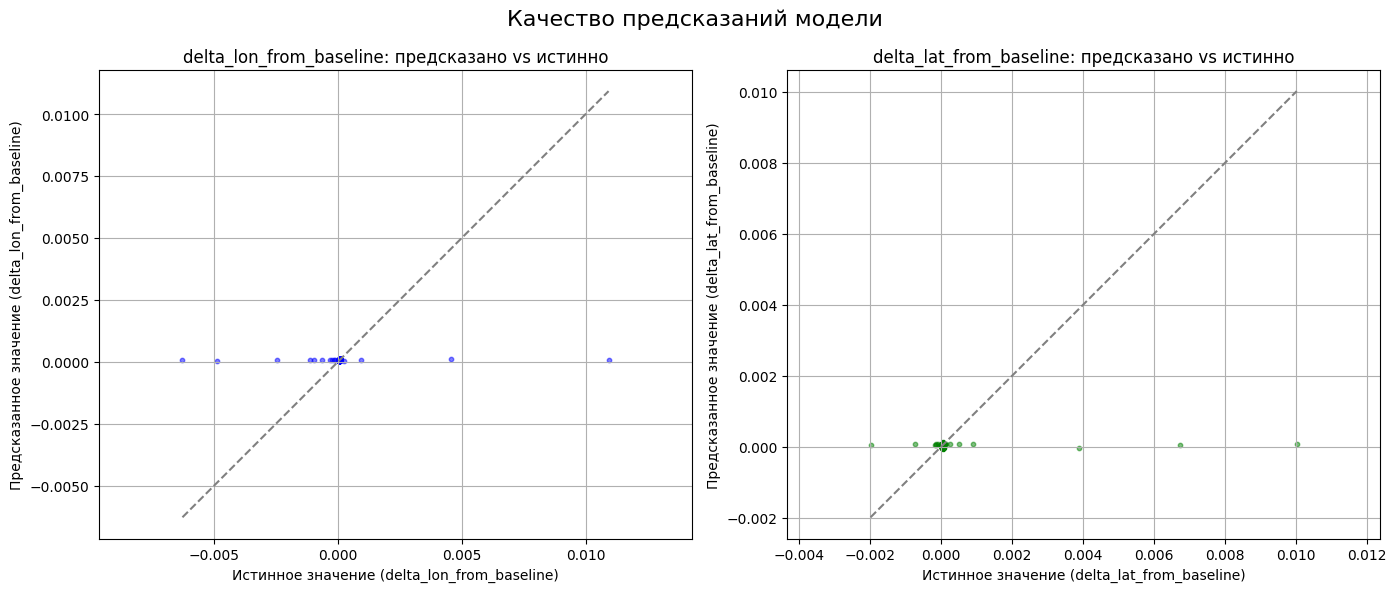

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

models = {
    "LR": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RANSAC": RANSACRegressor(),
    "Poly2 + LR": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

model_name = "Poly2 + LR"

# Обучение модели

#model = LinearRegression() # ver 1c.0
lr_model = models[model_name] # ver 1c.0

lr_model.fit(X_train, y_train)

# Предсказание
y_pred = lr_model.predict(X_test)

print("=== y_test ===")
print(type(y_test))
print(y_test.shape)
print(y_test.columns if isinstance(y_test, pd.DataFrame) else "Not a DataFrame")

print("=== y_pred ===")
print(type(y_pred))
print(y_pred.shape)

df_predictions = save_model_predictions(y_test, y_pred, model_name, filename=RESULTS_DIR+f"predictions_{model_name}_{LR_VERSION}.csv", X_original=X_test_full)

# Метрики
mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target = calculate_metrics(y_test, y_pred)
print_metrics(mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)
print("-" * 20)
print_advanced_metrics(y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)

print("Mean y_true:", np.mean(y_test.values, axis=0))
print("Mean y_pred:", np.mean(y_pred, axis=0))

# Оценка геометрии полигонов
if MODE == "POINTS":
    df_geo_metrics = save_evaluation_polygon_geometry(df_predictions, model_name, LR_VERSION, RESULTS_DIR)

metrics_list.append(collect_metrics_dict(model_name, y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target))

# Визуализация
plot_predictions_vs_true(y_test, y_pred)

In [19]:
display(df_predictions[df_predictions["number"] == "4625382600:02:000:0270"])

,true_delta_lon_from_baseline,true_delta_lat_from_baseline,pred_delta_lon_from_baseline,pred_delta_lat_from_baseline,sc63_centroid_x,sc63_centroid_y,number,pred_lon,pred_lat,err_delta_lon_from_baseline,err_delta_lat_from_baseline,err_dist_deg,err_delta_lon_from_baseline_m,err_delta_lat_from_baseline_m,err_dist_m,model
1504,0.000072,0.000056,0.000073,0.000046,1317939.43,5453425.15,4625382600:02:000:0270,23.744885,49.295409,0.000001,-0.00001,0.00001,0.137033,-1.073887,1.082595,LR


##### - MLPRegressor

### 🧠 MLPRegressor (нейросеть)

- Описание: Полносвязная нейросеть (Multi-Layer Perceptron), обучается градиентным методом.

Параметры:
- hidden_layer_sizes=(64, 32) — два скрытых слоя;
- activation='relu', solver='adam';
- max_iter=1000, early_stopping=True.

Плюсы: может моделировать сложные зависимости.

Минусы: чувствительна к масштабу, требует настройки, переобучается.



✅ MLP saving corrected predictions
✅ Saved: ./mnt/results/predictions_MLP_v1c.0.csv
Metrics:
MAE = 0.000025
RMSE = 0.000309
MAE per target = [2.53834983e-05 2.42577294e-05]
RMSE per target = [0.00032873 0.00028923]
R2 per target = [-0.00025814 -0.00404984]
R2 = -0.002153988073617441
--------------------


,Value
Metric,
MAE (°),0.000025
RMSE (°),0.000309
MAE по delta_lon_from_baseline (°),0.000025
MAE по delta_lat_from_baseline (°),0.000024
RMSE по delta_lon_from_baseline (°),0.000329
RMSE по delta_lat_from_baseline (°),0.000289
MAE по delta_lon_from_baseline (м),2.830000
MAE по delta_lat_from_baseline (м),2.690000
MAPE (%),21.060000


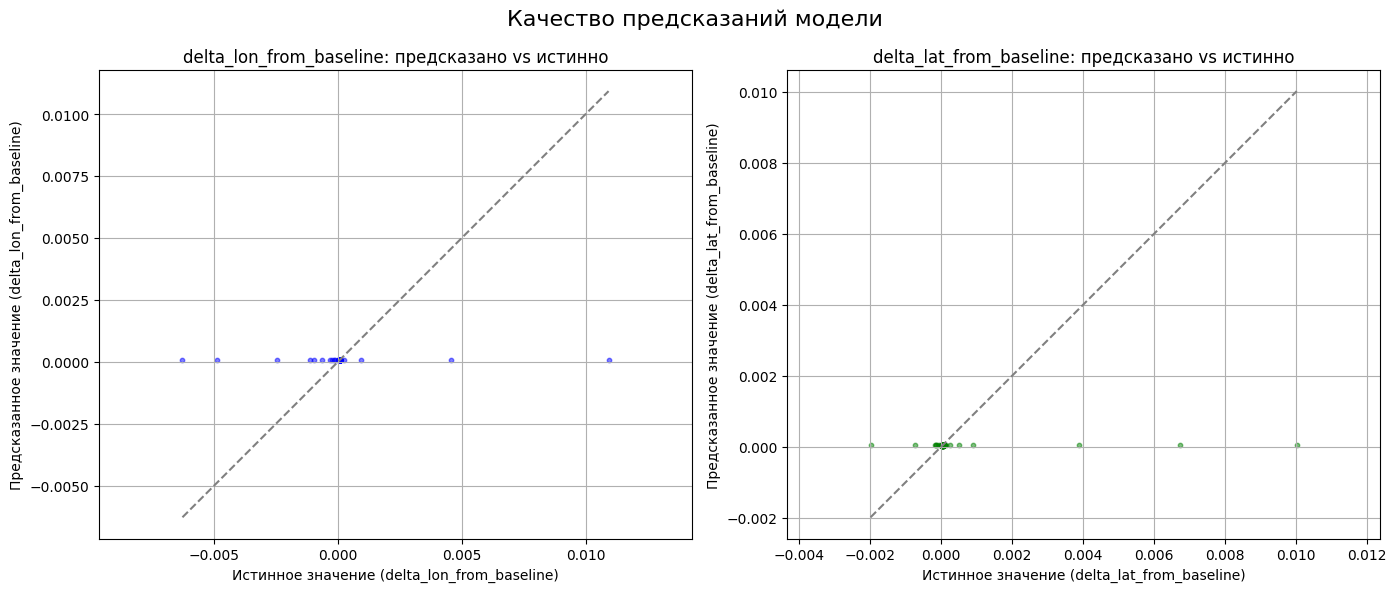

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler


# Масштабируем входы (MLP чувствителен к масштабу)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# ВАЖНО! скалировать и целевую переменную, т.к. отклонения имеют очень малый масштаб 
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# Обучение простой MLP модели
mlp_model = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', solver='adam',
                   max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Предсказания
y_pred_scaled = mlp_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

save_model_predictions(y_test, y_pred, "MLP", filename=RESULTS_DIR+f"predictions_MLP_{MLP_VERSION}.csv", X_original=X_test_full)

# Метрики
mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target = calculate_metrics(y_test, y_pred)
print_metrics(mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)
print("-" * 20)
print_advanced_metrics(y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)
# Оценка геометрии полигонов
if MODE == "POINTS":
    df_geo_metrics = save_evaluation_polygon_geometry(df_predictions, "MLP", MLP_VERSION, RESULTS_DIR)

metrics_list.append(collect_metrics_dict("MLP", y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target))

# Визуализация
plot_predictions_vs_true(y_test, y_pred)


##### - HistGradientBoosting

### 🌲 HistGradientBoosting / XGBoost (опционально)

- Описание: Сильные бустинговые модели для табличных данных.
- Параметры: множество (learning_rate, n_estimators, max_depth и др.)
- Плюсы: высокая точность.
- Минусы: склонность к переобучению, чувствительны к малым данным, сложные для отладки.

✅ HGB saving corrected predictions
✅ Saved: ./mnt/results/predictions_HGB_v1c.0.csv
Metrics:
MAE = 0.000049
RMSE = 0.000330
MAE per target = [5.63999505e-05 4.20560848e-05]
RMSE per target = [0.00035505 0.00030476]
R2 per target = [-0.16687482 -0.11475615]
R2 = -0.14081548711240477
--------------------


,Value
Metric,
MAE (°),0.000049
RMSE (°),0.000330
MAE по delta_lon_from_baseline (°),0.000056
MAE по delta_lat_from_baseline (°),0.000042
RMSE по delta_lon_from_baseline (°),0.000355
RMSE по delta_lat_from_baseline (°),0.000305
MAE по delta_lon_from_baseline (м),6.280000
MAE по delta_lat_from_baseline (м),4.670000
MAPE (%),60.460000


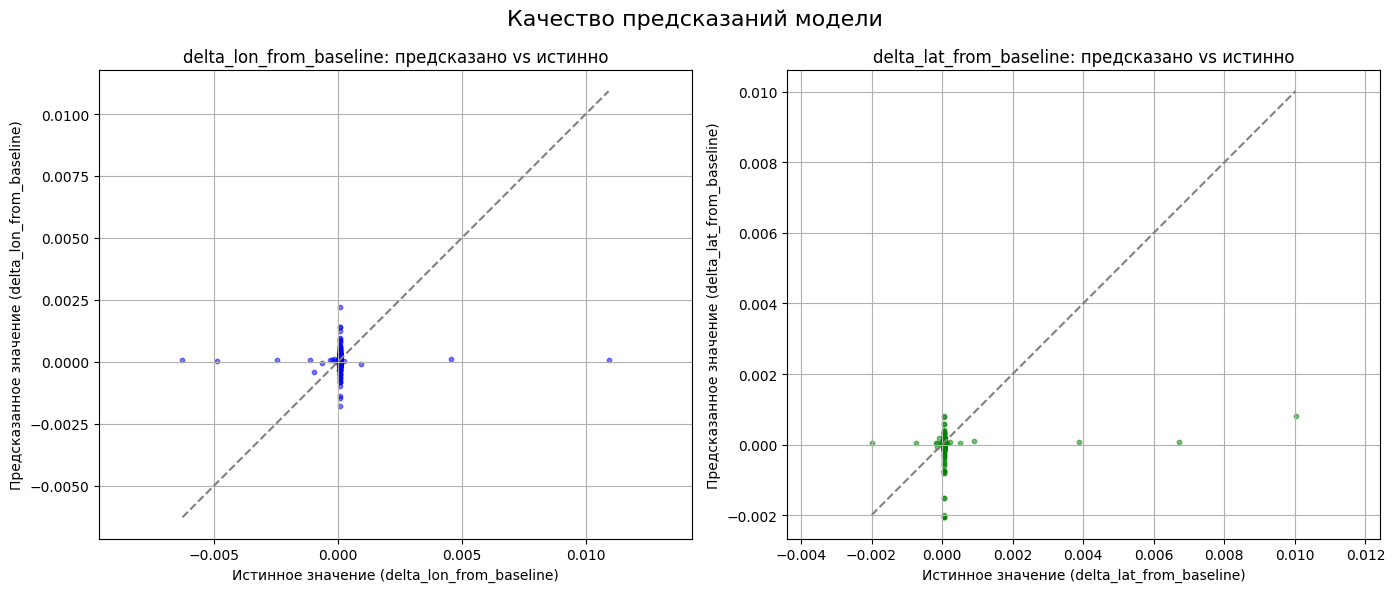

In [20]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Обучим две модели: отдельно для lon и lat
hgb_lon = HistGradientBoostingRegressor(max_iter=200, random_state=42)
hgb_lat = HistGradientBoostingRegressor(max_iter=200, random_state=42)

# Обучение
col_1, col_2 = y_train.columns[:2]
hgb_lon.fit(X_train, y_train[col_1].values)
hgb_lat.fit(X_train, y_train[col_2].values)

# Предсказание
y_pred = np.column_stack([
    hgb_lon.predict(X_test),
    hgb_lat.predict(X_test)
])

save_model_predictions(y_test, y_pred, "HGB", filename=RESULTS_DIR+f"predictions_HGB_{HGB_VERSION}.csv", X_original=X_test_full)

# Метрики
mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target = calculate_metrics(y_test, y_pred)
print_metrics(mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)
print("-" * 20)
print_advanced_metrics(y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)
# Оценка геометрии полигонов
if MODE == "POINTS":
    df_geo_metrics = save_evaluation_polygon_geometry(df_predictions, "HGB", HGB_VERSION, RESULTS_DIR)

metrics_list.append(collect_metrics_dict("HGB", y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target))

# Визуализация
plot_predictions_vs_true(y_test, y_pred)

##### - XGBoost

=== y_test ===
<class 'pandas.core.frame.DataFrame'>
(1973, 2)
Index(['delta_lon_from_baseline', 'delta_lat_from_baseline'], dtype='object')
=== y_pred ===
<class 'numpy.ndarray'>
(1973, 2)
✅ XGB saving corrected predictions
✅ Saved: ./mnt/results/predictions_XGB_v1c.0.csv
Metrics:
MAE = 0.000026
RMSE = 0.000323
MAE per target = [2.80791123e-05 2.32032445e-05]
RMSE per target = [0.00034928 0.00029579]
R2 per target = [-0.12923694 -0.05010664]
R2 = -0.089671790599823
--------------------


,Value
Metric,
MAE (°),0.000026
RMSE (°),0.000323
MAE по delta_lon_from_baseline (°),0.000028
MAE по delta_lat_from_baseline (°),0.000023
RMSE по delta_lon_from_baseline (°),0.000349
RMSE по delta_lat_from_baseline (°),0.000296
MAE по delta_lon_from_baseline (м),3.130000
MAE по delta_lat_from_baseline (м),2.580000
MAPE (%),22.390000


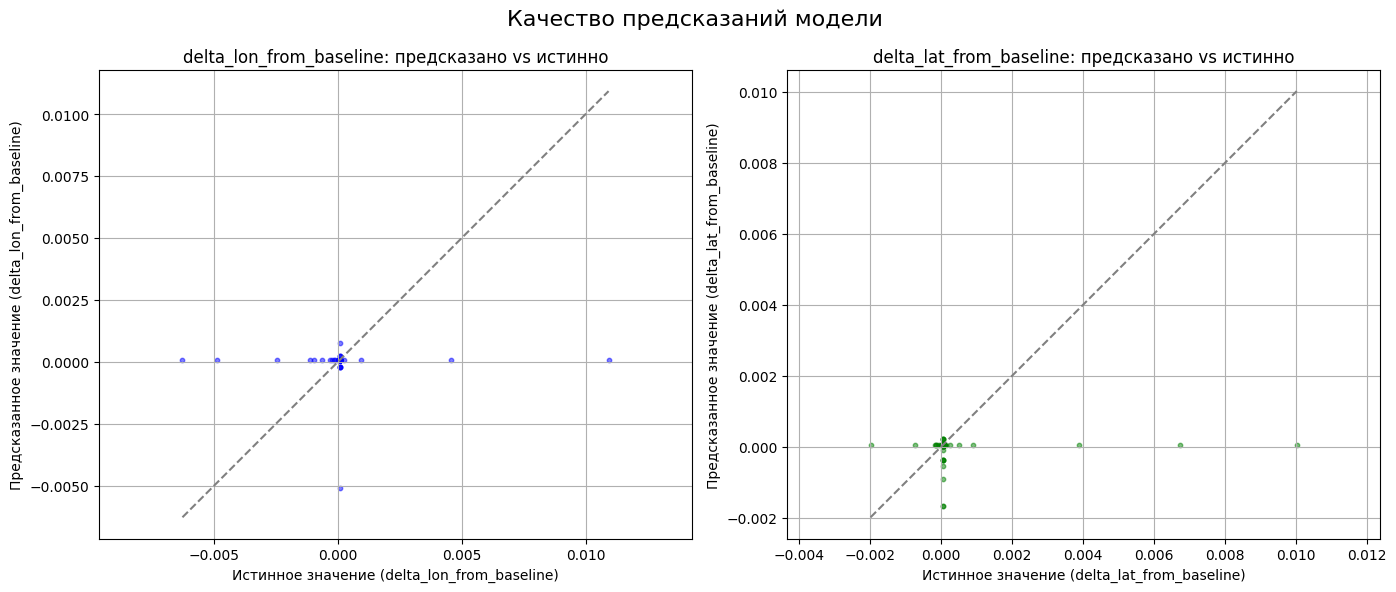

In [21]:
# Обучение XGBoost модели
import xgboost as xgb
from xgboost import XGBRegressor

# Обучение
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)
xgb_model.fit(X_train, y_train)

# Предсказание
y_pred = xgb_model.predict(X_test)

print("=== y_test ===")
print(type(y_test))
print(y_test.shape)
print(y_test.columns if isinstance(y_test, pd.DataFrame) else "Not a DataFrame")

print("=== y_pred ===")
print(type(y_pred))
print(y_pred.shape)

df_predictions = save_model_predictions(y_test, y_pred, "XGB", filename=RESULTS_DIR+f"predictions_XGB_{XGB_VERSION}.csv", X_original=X_test_full)

# Метрики
mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target = calculate_metrics(y_test, y_pred)
print_metrics(mae, rmse, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)
print("-" * 20)
print_advanced_metrics(y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target)

# Оценка геометрии полигонов
if MODE == "POINTS":
    df_geo_metrics = save_evaluation_polygon_geometry(df_predictions, "XGB", XGB_VERSION, RESULTS_DIR)

metrics_list.append(collect_metrics_dict("XGB", y_test, y_pred, mae_per_target, rmse_per_target, r2_score, r2_score_per_target))

# Визуализация
plot_predictions_vs_true(y_test, y_pred)

 ##### - LightGBM

In [25]:
# сохраним метрики в CSV файл
pd.DataFrame(metrics_list).to_csv(RESULTS_DIR+f"metrics_summary_{GLOBAL_VERSION}.csv", index=False)

#### 🔹 4. Сравнение моделей: MAE, RMSE, MAPE


#### 🔹 5. Сохранение предсказаний: predictions_MODEL.csv

#### 🔹 6. Анализ и визуализация:
- scatter predicted vs true
- loss curves (MLP)
- диаграммы ошибок

In [ ]:
# Анализ гемоетрии полигонов: предсказания vs истинные значения
models = ["LR_"+LR_VERSION, "MLP_"+MLP_VERSION, "HGB_"+HGB_VERSION]
if MODE == "POINTS":
    visualisation_polygon_form_metrics(models, highlight_model="HGB_"+HGB_VERSION)

In [23]:
# Папка с результатами
results_path = Path(RESULTS_DIR)

# Загружаем все summary-файлы метрик по координатам
metric_files = list(results_path.glob("metrics_summary_v*.csv"))
metric_data = []

for file in metric_files:
    df = pd.read_csv(file)
    version = file.stem.split("_v")[-1]
    df["version"] = f"v{version}"
    metric_data.append(df)

# Объединяем в одну таблицу
df_metrics = pd.concat(metric_data).reset_index(drop=True)

if MODE == "POINTS":
    df_metrics = df_metrics[~df_metrics["version"].str.contains("c")]
else:
    df_metrics = df_metrics[df_metrics["version"].str.contains("c")]

df_metrics.dropna(axis=1, how="all", inplace=True)

# Приводим к удобному виду: округление и сортировка
df_metrics = df_metrics.round(5)
df_metrics = df_metrics.sort_values(by=["model", "version"])

cols = ['model', 'version'] + [col for col in df_metrics.columns if col not in ['model', 'version']]
df_metrics = df_metrics[cols]

# Подгружаем файл с центроидами и считаем MAE (baseline до модели)
centroids_df = pd.read_csv(CENTROIDS_CSV_PATH)
centroids_df = centroids_df[centroids_df["zone"] != 0]  # исключаем нулевую зону

# Перевод в метры
mean_lat = centroids_df["wgs84_centroid_lat"].mean()
lon_factor = 111320 * np.cos(np.radians(mean_lat))
lat_factor = 111000

centroids_df["baseline_err_lon_m"] = np.abs(centroids_df["delta_lon_from_baseline"]) * lon_factor
centroids_df["baseline_err_lat_m"] = np.abs(centroids_df["delta_lat_from_baseline"]) * lat_factor
centroids_df["baseline_err_total_m"] = np.sqrt(
    centroids_df["baseline_err_lon_m"]**2 + centroids_df["baseline_err_lat_m"]**2
)

baseline_mae_m = centroids_df["baseline_err_total_m"].mean()

# Вторая таблица: сравнение MAE до и после модели
df_compare = df_metrics[["model", "version"]].copy()
df_compare["Baseline MAE (m)"] = baseline_mae_m
df_compare["Model MAE (m)"] = np.sqrt(df_metrics[[c for c in df_metrics.columns if "MAE" in c and "(m)" in c]].pow(2).sum(axis=1))
df_compare["Improvement (%)"] = 100 * (1 - df_compare["Model MAE (m)"] / df_compare["Baseline MAE (m)"])
df_compare = df_compare.round(2)


# Вывод
display(HTML("<h4>📊 Метрики моделей</h4>"))
display(HTML(df_metrics.to_html(index=False)))

display(HTML("<h4>📉 Сравнение с baseline (до модели)</h4>"))
display(HTML(df_compare.to_html(index=False)))



model,version,MAE (°),RMSE (°),MAPE (%),n_samples,MAE delta_lon_from_baseline (°),MAE delta_lat_from_baseline (°),MAE delta_lon_from_baseline (m),MAE delta_lat_from_baseline (m),MAPE delta_lon_from_baseline (%),MAPE delta_lat_from_baseline (%),R2 delta_lon_from_baseline,R2 delta_lat_from_baseline,R2
ElasticNet,v1c.0,0.00002,0.00031,20.75885,1973,0.00003,0.00002,2.80764,2.67268,19.04981,22.46790,-0.00003,-0.00393,-0.00198
HGB,v1c.0,0.00005,0.00033,60.46356,1973,0.00006,0.00004,6.27844,4.66823,62.80684,58.12028,-0.16687,-0.11476,-0.14082
LR,v1c.0,0.00003,0.00031,23.31386,1973,0.00002,0.00003,2.43736,3.21524,12.56775,34.05998,0.00210,-0.00559,-0.00174
Lasso,v1c.0,0.00002,0.00031,20.75885,1973,0.00003,0.00002,2.80764,2.67268,19.04981,22.46790,-0.00003,-0.00393,-0.00198
MLP,v1c.0,0.00446,0.00759,8951.82524,1973,0.00468,0.00423,521.18171,469.76917,8082.91728,9820.73320,-603.44221,-604.08676,-603.76449
Poly2 + LR,v1c.0,0.00003,0.00031,29.27898,1973,0.00002,0.00003,2.70147,3.70269,15.22454,43.33343,0.00305,-0.01405,-0.00550
RANSAC,v1c.0,0.00002,0.00031,8.05043,1973,0.00002,0.00002,2.32520,1.69390,10.58383,5.51703,0.00185,0.00150,0.00168
Ridge,v1c.0,0.00003,0.00031,23.28942,1973,0.00002,0.00003,2.43692,3.21315,12.56185,34.01699,0.00210,-0.00557,-0.00174
XGB,v1c.0,0.00003,0.00032,22.38785,1973,0.00003,0.00002,3.12577,2.57556,22.73508,22.04061,-0.12924,-0.05011,-0.08967


model,version,Baseline MAE (m),Model MAE (m),Improvement (%)
ElasticNet,v1c.0,10.35,3.88,62.55
HGB,v1c.0,10.35,7.82,24.41
LR,v1c.0,10.35,4.03,61.02
Lasso,v1c.0,10.35,3.88,62.55
MLP,v1c.0,10.35,701.65,-6679.13
Poly2 + LR,v1c.0,10.35,4.58,55.72
RANSAC,v1c.0,10.35,2.88,72.21
Ridge,v1c.0,10.35,4.03,61.04
XGB,v1c.0,10.35,4.05,60.87


In [ ]:
centroids_predictions = pd.read_csv(RESULTS_DIR+f"predictions_LR_{LR_VERSION}.csv")
centroids_df_filtered = centroids_df[centroids_df["zone"] != 0].copy()

centroids_df_filtered = centroids_df_filtered[["number","zone","baseline_err_total_m"]].join(centroids_predictions[["number","err_dist_m"]].set_index("number"), on="number", how="inner")

centroids_df_filtered["better"] = centroids_df_filtered["baseline_err_total_m"] - centroids_df_filtered["err_dist_m"]
centroids_df_filtered["better_pct"] = centroids_df_filtered["better"]/centroids_df_filtered["baseline_err_total_m"] * 100
centroids_df_filtered["better"] = centroids_df_filtered["better"].round(2)
centroids_df_filtered["baseline_err_total_m"] = centroids_df_filtered["baseline_err_total_m"].round(2)
centroids_df_filtered["err_dist_m"] = centroids_df_filtered["err_dist_m"].round(2)

centroids_df_filtered = centroids_df_filtered.rename(columns={"baseline_err_total_m": "calculation error", "err_dist_m": "model error", "better": "performance", "better_pct": "performance (%)"})
display(
    HTML(
        centroids_df_filtered
        .groupby("zone")[["calculation error", "model error", "performance", "performance (%)"]]
        .agg(["mean","std"])
        .round(2)
        .to_html(index=True, justify="center")
    )
)



In [ ]:
centroids_df_filtered